In [13]:
import os
import numpy as np
import cv2
import glob
import sys
from typing import List, Tuple

In [14]:
def GET_PROJECT_ROOT():
    current_abspath = os.path.abspath('./')
    while True:
        if os.path.split(current_abspath)[1] == 'Image-Retrieval-Simple-System-With-Streamlit':
            project_root = current_abspath
            break
        else:
            current_abspath = os.path.dirname(current_abspath)
    return project_root

PROJECT_ROOT = GET_PROJECT_ROOT()
os.chdir(PROJECT_ROOT)
sys.path.append(PROJECT_ROOT)


In [15]:
print(f"Current working directory: {os.getcwd()}")

Current working directory: d:\BachKhoa\AIO-Projects\OwnProject\Image-Retrieval-Simple-System-With-Streamlit


In [16]:
ROOT = './data/processed'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train'))) # A list of ClassName from ImageNetV1
SIZE = (448, 448)
ROOT_IMAGE_PATH = './data/processed/train'
QUERY_PATH = './data/processed/test/Orange_easy/0_100.jpg'


In [17]:
# # tesing folder_to_images function
# image_numpy, images_path = folder_to_images(
#     folder=ROOT_IMAGE_PATH,
#     size=SIZE,
# )

# List of query types: L1, L2, Cosine, Correlation(Optional)

In [22]:
class SimpleImageRetrieval:
    """
    A class for calculating image similarity using various metrics

    """
    def __init__(
            self, *, 
            root_image_path: str, 
            query_path: str,
            size: Tuple[int, int],
            metric: str = 'cosine'    
        ) -> None:
        """Initialize the SimpleImageRetrieval

        Args:
            root_image_path (str): Path to the root directory containing the image folders, as a database
            query_path (str): The path to the query image, where user want to retrieval several semnatically similar images from the databse folder
            size (Tuple[int, int]): Size the resize images to (height, width)
            metric (str, optional): Similarity metric to use. Defaults to 'cosine'.
        """
        self.root_img_path = root_image_path
        self.query_path = query_path
        self.size = size
        self.query = self.read_image_from_path(path=query_path, size=size)
        self.metric = metric

    def read_image_from_path(
        self,
        *,
        path: str, 
        size: Tuple[int, int]
    ) -> np.ndarray:
        """Read the image from the path, covnert to RGB, resize it, and returns a numpy array

        Args:
            path (str): The file path of the image
            Tuple (_type_): the Target size of the image (width, height)

        Returns:
            np.ndarray: The image is processed as numpy array through cv2
        """
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, size)
        return image
    
    
    def folder_to_images(self, *, folder: str, size: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
        """Converts all images into np.ndarray and returns them, also returns the path leads to these images

        Args:
            folder (str): The folder path containing the images
            size (Tuple[int, int]): The target size of the images as (width, height)

        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple containing:
                - A NumPy array of the processed images.
                - A NumPy array of the image paths.
        """
        list_dir = [folder + '/' + name for name in os.listdir(folder)]
        
        images_np = np.zeros((len(list_dir), *size, 3) , dtype=np.uint8) # it will be (number of listdir, width, height, 3)
        images_path = []
        for i, path in enumerate(list_dir):
            images_np[i] = self.read_image_from_path(path=path, size=size)
            images_path.append(path)
        
        images_path = np.array(images_path)
        return images_np, images_path
    
    def absolute_difference(self, *, query: np.ndarray, data: np.ndarray) -> np.ndarray:
        axis_batch_size = tuple(range(1, len(data.shape)))
        return np.sum(np.abs(data - query), axis=axis_batch_size)

    def mean_square_difference(self, *, query: np.ndarray, data: np.ndarray) -> np.ndarray:
        axis_batch_size = tuple(range(1, len(data.shape)))
        return np.sqrt(np.mean((data - query)**2, axis=axis_batch_size))

    def cosine_similarity(self, *, query: np.ndarray, data: np.ndarray) -> np.ndarray:
        
        query_norm = np.sqrt(np.sum(query**2))

        axis_batch_size = tuple(range(1, len(data.shape)))
        data_norm = np.sqrt(np.sum(data**2, axis=axis_batch_size))


        dot_product = np.sum(query * data, axis=axis_batch_size)
        return dot_product / (query_norm * data_norm + np.finfo(float).eps)
    
    def correlation_coefficient(
        self,
        *,
        query: np.ndarray,
        data: np.ndarray
    ):
        """
        Calculate the correlation coefficient between query and data.

        Args:
            query (np.ndarray): Query image.
            data (np.ndarray): Batch of images to compare against.

        Returns:
            np.ndarray: Array of correlation coefficients.
        """
        axis_batch_size = tuple(range(1, len(data.shape)))
        query_mean = query - np.mean(query)
        data_mean = data - np.mean(data, axis=axis_batch_size, keepdims=True)

        query_norm = np.sqrt(np.sum(query_mean ** 2))
        data_norm = np.sqrt(np.sum(data_mean ** 2, axis=axis_batch_size))

        return np.sum(data_mean * query_mean, axis=axis_batch_size) / (query_norm * data_norm + np.finfo(float).eps)
    
    def calculate_similarity(
            self, 
            metric: str, 
            query: np.ndarray, 
            data: np.ndarray
        ) -> np.ndarray:
        """
        Calculate similarity between query and data using the specified metric.

        Args:
            metric (str): Similarity metric to use ('l1', 'l2', 'cosine', 'correlation').
            query (np.ndarray): Query image.
            data (np.ndarray): Batch of images to compare against.

        Returns:
            np.ndarray: Array of similarity scores.

        Raises:
            ValueError: If an unsupported metric is specified.
        """
        if metric == 'l1':
            return self.absolute_difference(query=query, data=data)
        elif metric == 'l2':
            return self.mean_square_difference(query=query, data=data)
        elif metric == 'cosine':
            return self.cosine_similarity(query=query, data=data)
        elif metric == 'correlation':
            return self.correlation_coefficient(query=query, data=data)
        else:
            raise ValueError("Unsupported metric. Choose from 'l1', 'l2', 'cosine', 'correlation'.")
        
    def get_similarity_score(self) -> Tuple[np.ndarray, List[Tuple[str, float]]]:
        """
        Calculate similarity scores between the query image and all images in the dataset.

        Returns:
            Tuple[np.ndarray, List[Tuple[str, float]]]: A tuple containing the query image
            and a list of tuples with image paths and their corresponding similarity scores.
        """
        ls_path_score = []
  

        for folder in os.listdir(self.root_img_path):
            if folder in CLASS_NAME:
                path = os.path.join(self.root_img_path, folder)
                images_np, images_path = self.folder_to_images(folder=path, size=self.size)
                rates = self.calculate_similarity(self.metric, self.query, images_np)
                ls_path_score.extend(list(zip(images_path, rates)))
                
        return self.query, ls_path_score


In [23]:
similarity_retrieval_engine = SimpleImageRetrieval(
    root_image_path= ROOT_IMAGE_PATH,
    query_path= QUERY_PATH,
    size= SIZE,
    metric= 'cosine'
)
query, ls_path_score = similarity_retrieval_engine.get_similarity_score()

In [26]:
import matplotlib.pyplot as plt
import cv2
import math
from typing import List, Tuple

def plot_similarity(
    query_image: np.ndarray,
    score_list: List[Tuple[str, float]]
):
    """
    Plot the query image and the top similar images in a grid layout with 3 columns.

    Args:
    query_image (np.ndarray): The query image as a numpy array.
    score_list (List[Tuple[str, float]]): List of tuples containing image paths and their similarity scores.
    """
    score_list.sort(key=lambda x: x[1], reverse=False)

    num_results = min(len(score_list), 20)

    num_rows = math.ceil((num_results + 1) / 3)  # +1 for the query image

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    if num_rows == 1:
        axes = axes.reshape(1, -1)

    axes[0, 0].imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Query Image')
    axes[0, 0].axis('off')

    for i, (img_path, score) in enumerate(score_list[:num_results], start=1):
        row = i // 3
        col = i % 3
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[row, col].imshow(image)
        axes[row, col].set_title(f'Similarity: {score:.2f}')
        axes[row, col].axis('off')

    for i in range(num_results + 1, num_rows * 3):
        row = i // 3
        col = i % 3
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

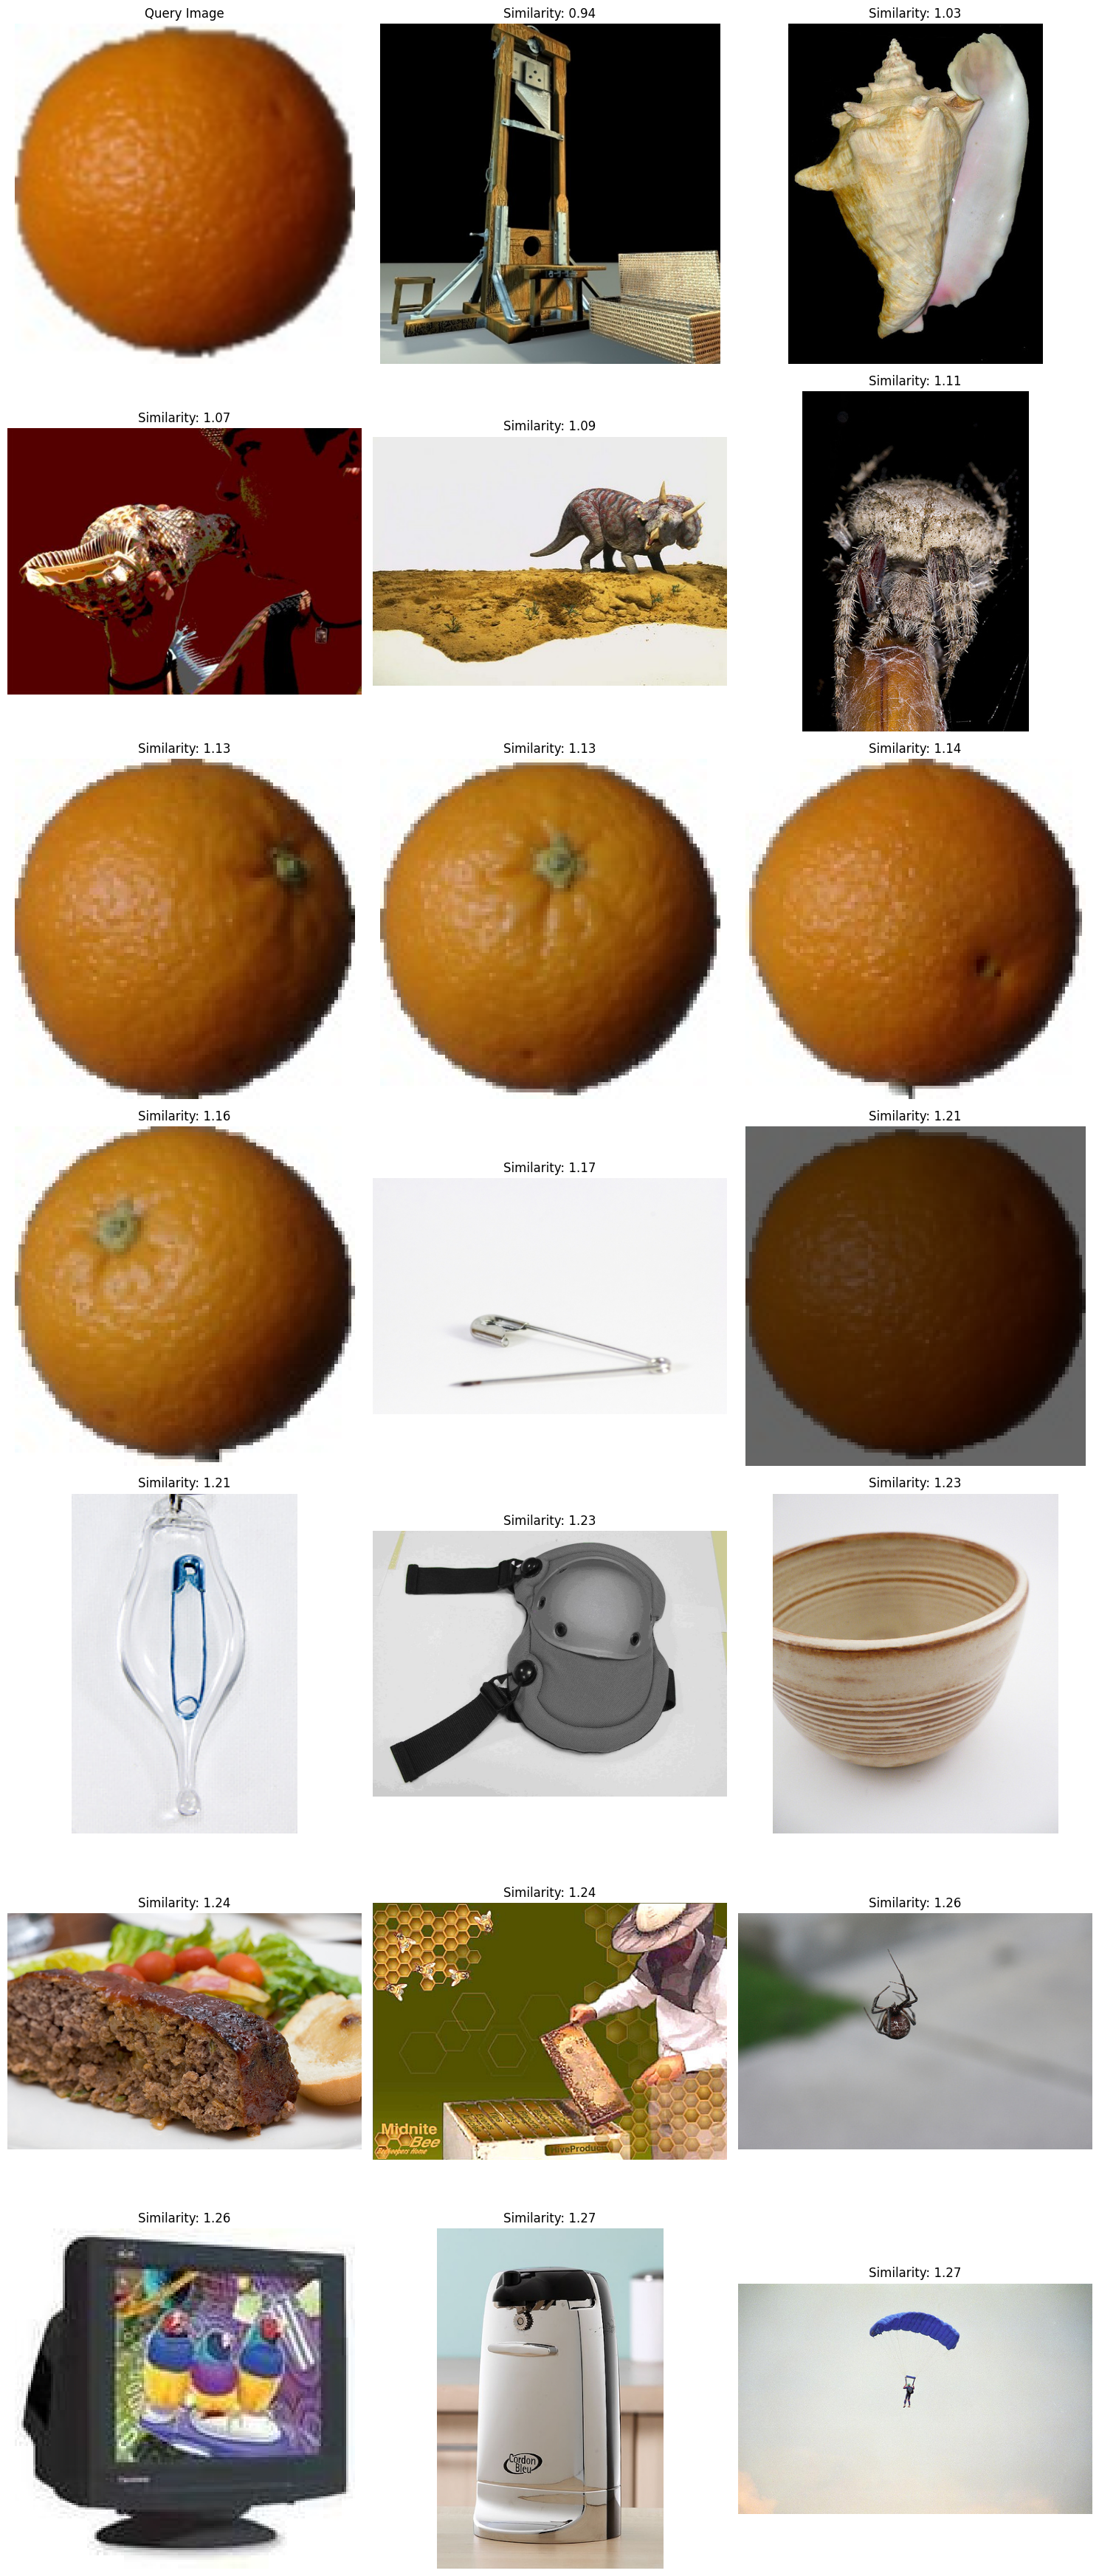

In [27]:
plot_similarity(
    query_image=query[:, :, ::-1],
    score_list=ls_path_score
)